<a href="https://colab.research.google.com/github/neuralsrg/SequenceModels/blob/main/machine_translation/NMT_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation with Attention Model

In [1]:
! pip install faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.4 MB/s 


In [2]:
from faker import Faker # generates random dates
import numpy as np 
from tqdm import trange
import babel.dates
import tensorflow as tf

## Generate dates dataset

In [3]:
def generate_dataset(m : int):

  generator = Faker()
  FORMATS = ['short', 'medium', 'long', 'full', 'd MM YY', 'd MMM YYY',
             'd MMMM YYY', 'd MMM, YYY', 'd MMMM, YYY', 'dd, MMM YYY', 'd MM YY',
             'MMMM d YYY', 'MMMM d, YYY', 'dd.MM.YY']
  PROBS = [.04, .04, .04, .44, .04, .08, .04, .04, .04, .04, .04, 0.04, .04, .04]

  Tx = 30
  dataset = []
  human = set()
  machine = set()

  for i in trange(m):
    date_object = generator.date_object()

    human_readable = babel.dates.format_date(date_object,
                                              format=np.random.choice(FORMATS, p=PROBS),
                                              locale='en_US')
    human_readable = human_readable.lower().replace(',','')
    machine_readable = date_object.isoformat()

    dataset.append((human_readable, machine_readable))
    human.update(tuple(human_readable))
    machine.update(tuple(machine_readable))

  human = dict(zip(sorted(human) + ['<unk>', '<pad>'], 
                     list(range(len(human) + 2))))
  inv_machine = dict(enumerate(sorted(machine)))
  machine = {v:k for k,v in inv_machine.items()}

  return dataset, human, machine, inv_machine

In [4]:
dataset, human_vocab, machine_vocab, inv_machine_vocab = generate_dataset(10000)
dataset[:10]

100%|██████████| 10000/10000 [00:01<00:00, 5154.13it/s]


[('21 feb 1993', '1993-02-21'),
 ('tuesday november 20 1984', '1984-11-20'),
 ('friday april 15 2022', '2022-04-15'),
 ('11 06 12', '2012-06-11'),
 ('thursday april 19 1973', '1973-04-19'),
 ('9 apr 1971', '1971-04-09'),
 ('wednesday january 27 1982', '1982-01-27'),
 ('tuesday june 14 1994', '1994-06-14'),
 ('saturday june 16 2012', '2012-06-16'),
 ('monday february 8 2016', '2016-02-08')]

In [5]:
# here we implent text encoding manually, but we also could use tf.keras.layers.TextVectorization

def encode(expression : str, Tx : int, v : dict):

  #expression = expression.replace(',', '')
  expression = expression.lower() if len(expression) <= Tx \
      else expression.lower()[:Tx]
  encoding = list(map(lambda x: v.get(x, '<unk>'), expression)) # encoding or <unk> if not found
  if len(expression) < Tx:
    encoding += [v['<pad>']] * (Tx - len(expression))

  return encoding


def decode(encoding : list, inverse_v : dict):
  
  return [inverse_v[i] for i in encoding]

In [6]:
Tx, Ty = 30, 10

X, Y = zip(*dataset)
X = np.array([encode(x, Tx, human_vocab) for x in X])
Y = np.array([encode(y, Ty, machine_vocab) for y in Y])

X_onehot = np.array(list(map(lambda x: \
    tf.keras.utils.to_categorical(x, num_classes=len(human_vocab)), X)))
Y_onehot = np.array(list(map(lambda y: \
    tf.keras.utils.to_categorical(y, num_classes=len(machine_vocab)), Y)))

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("X_onehot.shape:", X_onehot.shape)
print("Y_onehot.shape:", Y_onehot.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
X_onehot.shape: (10000, 30, 37)
Y_onehot.shape: (10000, 10, 11)


## Attention Model


![image](https://i.imgur.com/unr4XIk.png)

In [10]:
def create_model(Tx : int, Ty : int, n_a : int, n_s : int,
                 human_vocab_size : int, machine_vocab_size : int):

  # (num_samples, features) --> (num_samples, n, features)
  repeat_vector = tf.keras.layers.RepeatVector(n=Tx)
  concatenate = tf.keras.layers.Concatenate(axis=-1) # feature axis
  dense1 = tf.keras.layers.Dense(10, activation='tanh')
  dense2 = tf.keras.layers.Dense(1, activation='relu')
  activation = tf.keras.layers.Activation(activation=tf.nn.softmax, name='attention_weights')
  dot = tf.keras.layers.Dot(axes=1)

  def attention(a, s_prev):
    """
    Implements the attention block within neural net

    Arguments:
    a -- pre-attention Bi-LSTM hidden states (m, Tx, 2*n_a)
    s_prev -- previous post-attention LSTM hidden state (m, n_s)

    Returns:
    context -- input vector for post-attention LSTM
    """
    s_prev = repeat_vector(s_prev) # (m, Tx, n_s)
    concatenated = concatenate([a, s_prev]) # (m, Tx, 2n_a + n_s)
    energies = dense1(concatenated) # (m, Tx, 10)
    energies = dense2(energies) # (m, Tx, 1)
    weights = activation(energies) # (m, Tx, 1)
    context = dot([weights, a]) # (m, 2n_a)

    return context

  post_attention_LSTM = tf.keras.layers.LSTM(n_s, return_state=True)
  output_layer = tf.keras.layers.Dense(machine_vocab_size, activation='softmax')
  outputs = []

  x = tf.keras.layers.Input(shape=(Tx, human_vocab_size), name='x')
  s0 = tf.keras.layers.Input(shape=(n_s,), name='s0')
  c0 = tf.keras.layers.Input(shape=(n_s,), name='c0')
  s = s0
  c = c0

  LSTM = tf.keras.layers.LSTM(n_a, return_sequences=True)
  a = tf.keras.layers.Bidirectional(layer=LSTM, merge_mode='concat')(x)

  for t in range(Ty):

    context = attention(a, s)
    s, _, c = post_attention_LSTM(context, initial_state=[s, c])
    # here s - output (usually passed to dense layer), blank one is the last hidden_states
    # and c is the last memory state. s[:, -1, :] (in case return_sequences = True) == last hidden_state, But since 
    # return_sequences is set to False by default, s is 2-dimensional and s == last hidden_state
    output = output_layer(s)
    outputs.append(output)

  return tf.keras.Model(inputs=[x, s0, c0], outputs=outputs)

In [12]:
n_a = 32 # pre-attention hidden states
n_s = 64 # post-attention hidden states

model = create_model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x (InputLayer)                 [(None, 30, 37)]     0           []                               
                                                                                                  
 s0 (InputLayer)                [(None, 64)]         0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 30, 64)      17920       ['x[0][0]']                      
 )                                                                                                
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 30, 64)      0           ['s0[0][0]',               

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.005, decay=.01),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc']
)

In [15]:
model.output_shape

[(None, 11),
 (None, 11),
 (None, 11),
 (None, 11),
 (None, 11),
 (None, 11),
 (None, 11),
 (None, 11),
 (None, 11),
 (None, 11)]

In [18]:
m = 10000
batch_size = 100

s0 = np.zeros((m, n_s)) # fit() will batch them into (batch_size, n_s)
c0 = np.zeros((m, n_s))

outputs = list(Y_onehot.swapaxes(0, 1))
len(outputs)

10

In [19]:
model.fit(
    x=[X_onehot, s0, c0],
    y=outputs,
    epochs=10,
    verbose=1
)

Epoch 1/10
313/313 [==============================] - 44s 54ms/step - loss: 11.7234 - dense_8_loss: 0.4227 - dense_8_1_loss: 0.4355 - dense_8_2_loss: 1.0907 - dense_8_3_loss: 1.9952 - dense_8_4_loss: 0.6270 - dense_8_5_loss: 1.0300 - dense_8_6_loss: 1.9893 - dense_8_7_loss: 0.7091 - dense_8_8_loss: 1.3917 - dense_8_9_loss: 2.0323 - dense_8_acc: 0.9021 - dense_8_1_acc: 0.8828 - dense_8_2_acc: 0.6212 - dense_8_3_acc: 0.2708 - dense_8_4_acc: 0.8508 - dense_8_5_acc: 0.5521 - dense_8_6_acc: 0.2545 - dense_8_7_acc: 0.8051 - dense_8_8_acc: 0.4076 - dense_8_9_acc: 0.2514
Epoch 2/10
313/313 [==============================] - 19s 61ms/step - loss: 5.4371 - dense_8_loss: 0.1222 - dense_8_1_loss: 0.0908 - dense_8_2_loss: 0.5597 - dense_8_3_loss: 1.2553 - dense_8_4_loss: 0.0194 - dense_8_5_loss: 0.2524 - dense_8_6_loss: 1.1204 - dense_8_7_loss: 0.0239 - dense_8_8_loss: 0.7019 - dense_8_9_loss: 1.2910 - dense_8_acc: 0.9662 - dense_8_1_acc: 0.9670 - dense_8_2_acc: 0.7926 - dense_8_3_acc: 0.5244 - den

## Evaluating

In [23]:
dataset, human_vocab, machine_vocab, inv_machine_vocab = generate_dataset(1000)
dataset = dataset[:10]

X, Y = zip(*dataset)
X = np.array([encode(x, Tx, human_vocab) for x in X])
Y = np.array([encode(y, Ty, machine_vocab) for y in Y])

X_onehot = np.array(list(map(lambda x: \
    tf.keras.utils.to_categorical(x, num_classes=len(human_vocab)), X)))
Y_onehot = np.array(list(map(lambda y: \
    tf.keras.utils.to_categorical(y, num_classes=len(machine_vocab)), Y)))

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("X_onehot.shape:", X_onehot.shape)
print("Y_onehot.shape:", Y_onehot.shape)

100%|██████████| 1000/1000 [00:00<00:00, 4463.62it/s]

X.shape: (10, 30)
Y.shape: (10, 10)
X_onehot.shape: (10, 30, 37)
Y_onehot.shape: (10, 10, 11)


In [24]:
predictions = model.predict([X_onehot, np.zeros((10, n_s)), np.zeros((10, n_s))])
predictions = np.argmax(np.stack(predictions), axis=-1)
predictions.shape

(10, 10)

In [33]:
X, _ = zip(*dataset)

for x, predicted in zip(X, list(predictions.T)):
  print('{0:11}'.format('x :'), x)
  output = [inv_machine_vocab[int(p)] for p in predicted]
  print('predicted :', ''.join(output), '\n')


x :         23 mar 1986
predicted : 1986-03-23 

x :         saturday september 21 1996
predicted : 1996-09-21 

x :         thursday july 22 1971
predicted : 1971-07-22 

x :         august 7 2021
predicted : 2011-08-07 

x :         saturday december 26 2015
predicted : 2015-12-26 

x :         tuesday october 23 2012
predicted : 2012-10-23 

x :         thursday february 27 1975
predicted : 1975-02-27 

x :         23 december 1975
predicted : 1975-12-23 

x :         1 10 94
predicted : 1994-01-01 

x :         tuesday january 17 1995
predicted : 1995-01-17 



# Attention maps

In [34]:
import matplotlib.pyplot as plt

def plot_attention_map(model : tf.keras.Model, input_vocabulary : dict,
                       inv_output_vocabulary : dict, text : str,
                       n_s : int = 128, num : int = 7):

    attention_map = np.zeros((10, 30))
    layer = model.get_layer('attention_weights')

    Ty, Tx = attention_map.shape
    
    human_vocab_size = 37
    
    # Well, this is cumbersome but this version of tensorflow-keras has a bug that affects the 
    # reuse of layers in a model with the functional API. 
    # So, I have to recreate the model based on the functional 
    # components and connect then one by one.
    # ideally it can be done simply like this:
    # layer = modelx.layers[num]
    # f = Model(modelx.inputs, [layer.get_output_at(t) for t in range(Ty)])
    
    X = model.inputs[0] 
    s0 = model.inputs[1] 
    c0 = model.inputs[2] 
    s = s0
    c = s0
    
    a = model.layers[2](X)  
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = model.layers[3](s_prev)
        concat = model.layers[4]([a, s_prev]) 
        e = model.layers[5](concat) 
        energies = model.layers[6](e) 
        alphas = model.layers[7](energies) 
        context = model.layers[8]([alphas, a])
        s, _, c = model.layers[10](context, initial_state = [s, c]) 
        outputs.append(energies)

    f = tf.keras.Model(inputs=[X, s0, c0], outputs = outputs)
    

    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    encoded = np.array(encode(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: tf.keras.utils.to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    
    r = f([encoded, s0, c0])
        
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normalize attention map
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = decode(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

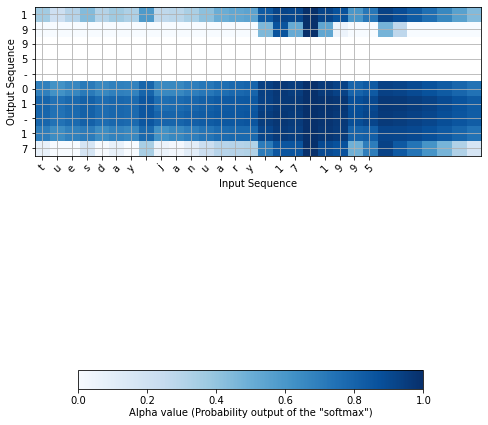

In [38]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab,
                                   "tuesday january 17 1995", n_s = 64)